## Imports

In [83]:
%run 'psd_mc_functions.ipynb'

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import os

In [2]:
import pandas as pd

## Functions

In [158]:
def read_pickles(dirname, base_name, max_i = None):
    if max_i is None:
        fns = os.listdir(dirname)
        fns = [os.path.join(dirname, fn) for fn in fns if base_name in fn]
        fns = np.sort(fns)
    else:
        fns = [os.path.join(dirname, base_name + '_%03d.pickle' % i) for i in range(max_i)]
    dicts = []
    for fn in fns:
        with open(fn, 'rb') as f:
            dicts.append(pickle.load(f))
    dicts =  np.concatenate(dicts)
    df = pd.DataFrame(list(dicts))
    if df.isnull().values.any():
        print('Warning: found some NaNs or Nones in the dataframe. Maybe check your computation results?')
    print('Read %d datapoints from %d files.' % (len(df), len(fns)))
    return df



In [4]:
def parslice_2d(df, x, y, **kwargs):
    '''
    Plot the minimum values of chi2 for two variables (i.e. a projection of the minimum onto the 2d slice)
    '''
    grouped = df.groupby(by = (x, y)).min()
    grouped[x] = grouped.index.get_level_values(x)
    grouped[y] = grouped.index.get_level_values(y)
    plt.scatter(grouped[x], grouped[y], c= grouped['chi2'], **kwargs)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.colorbar(label='chi2/ndf')
    plt.show()

In [74]:
def plot_all_slices(df, **kwargs):
    '''
    Inspect the 2d slices to find the minimum.
    '''
    x, y = ('t3', 'fs')
    parslice_2d(df, x, y, **kwargs)
    x, y = ('t1', 'tts')
    parslice_2d(df, x, y, **kwargs)
    x, y = ('t1', 't3')
    parslice_2d(df, x, y, **kwargs)
#     x, y = ('t3', 'tts')
#     parslice_2d(df, x, y, **kwargs)
#     x, y = ('fs', 'tts')
#     parslice_2d(df, x, y, **kwargs)
    return

In [6]:
def plot_slice_containing_point(df, x, y, row, **kwargs):
    df_sel = deepcopy(df)
    for key in row.keys():
        if (key == x) or (key == y) or (key=='chi2'):
            continue
        df_sel = df_sel[df_sel[key] == row[key]]
    plt.scatter(df_sel[x], df_sel[y], c= df_sel['chi2'], **kwargs)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.colorbar(label='chi2/ndf')
    plt.show()

In [163]:
def read_and_combine(dirname, list_of_base):
    df_list = []
    for base_name in list_of_base:
        df_list.append(read_pickles(dirname, base_name))
    df = pd.concat(df_list)
    return df

In [119]:
def get_some_minima(df, n_values):
    selected_minima = df.sort_values(by = 'chi2')[:n_values]
    print('Selected %d values with chi2 ranging from %.2f to %.2f...' % (len(selected_minima), 
                                                                         selected_minima['chi2'].min(),
                                                                        selected_minima['chi2'].max()))
    return deepcopy(selected_minima)

In [150]:
def check_minima(df, n_values, check_times):
    electa = get_some_minima(df, n_values)
    electa['ranking_before'] = range(len(electa))
    chi2_new = []
    for index, settings in electa.iterrows():
        print('Working on setting %d' % index)
        settings = dict(settings)
        gofs = [gof(**settings) for _ in range(check_times)]
        chi2_new.append(np.average(gofs))
    electa['chi2_new_%d_times' % check_times] = chi2_new
    electa = electa.sort_values(by = 'chi2_new_%d_times' % check_times)
    electa['ranking_after'] = range(len(electa))
    electa = electa.sort_values(by='chi2')
    changed = electa['ranking_before'] != electa['ranking_after']
    if sum(changed) != 0:
        print('Warning: I detected a changing order!')
    return electa


## Read data

In [201]:
df = read_pickles('/data/xenon/ehogenbi/pulsefit/processing_pickles/', 'highstat_withsys_er')
# df = read_and_combine('/data/xenon/ehogenbi/pulsefit/processing_pickles', 
#                       ['highstat_withsys_nr', 'highstat_withsys_nr2', 'highstat_withsys_nr2'])

Read 4459 datapoints from 17 files.


### The Best Fit Point

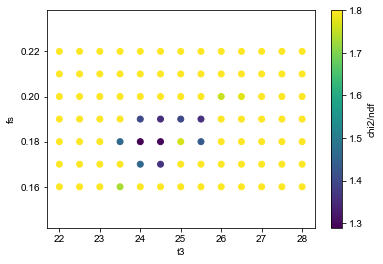

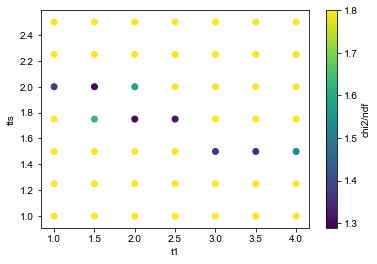

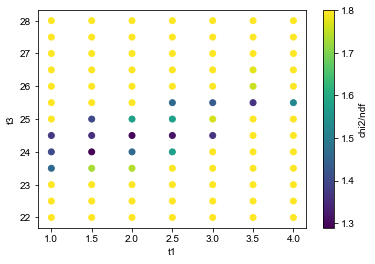

In [202]:
plot_all_slices(df, vmax=1.8)

In [203]:
minrow = df.iloc[df['chi2'].argmin()]

In [204]:
dict(minrow)

{'bootstrap_trials': 250,
 'chi2': 1.2889927184130863,
 'fs': 0.17999999999999999,
 'n_photons': 2000000,
 'neglect_systematic': False,
 't1': 1.5,
 't3': 24.0,
 'tts': 2.0}

In [181]:
get_some_minima(df, 10)

Selected 10 values with chi2 ranging from 1.27 to 1.51...


,bootstrap_trials,chi2,dset,fs,n_photons,neglect_systematic,t1,t3,tts
107,250,1.273933,nr,0.22,2000000,False,1.5,21.0,1.50
107,250,1.273933,nr,0.22,2000000,False,1.5,21.0,1.50
107,250,1.273933,nr,0.22,2000000,False,1.5,21.0,1.50
591,250,1.282838,nr,0.24,2000000,False,1.0,21.5,1.75
591,250,1.282838,nr,0.24,2000000,False,1.0,21.5,1.75
591,250,1.282838,nr,0.24,2000000,False,1.0,21.5,1.75
653,250,1.292329,nr,0.24,2000000,False,2.0,22.0,1.50
653,250,1.292329,nr,0.24,2000000,False,2.0,22.0,1.50
653,250,1.292329,nr,0.24,2000000,False,2.0,22.0,1.50
542,250,1.511376,nr,0.24,2000000,False,1.0,21.0,1.75


In [180]:
minrow

bootstrap_trials          250
chi2                  1.27393
dset                       nr
fs                       0.22
n_photons             2000000
neglect_systematic      False
t1                        1.5
t3                         21
tts                       1.5
Name: 107, dtype: object

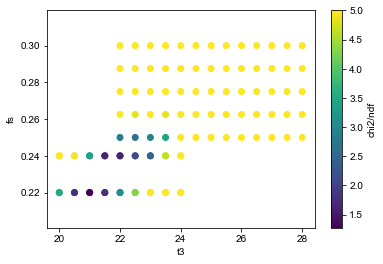

In [171]:
plot_slice_containing_point(df, 't3', 'fs', minrow, vmax=5)

### Manual check of best fit point

In [92]:
# del stored_stat
stored_stat = real_s1_wv_sigma(**minrow)

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/pandas/core/series.py:749: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc[key] = value


{'fs': 0.25, 't3': 22.5, 't1': 2.0, 's1_model': 'two_exp', 's1_min': 30, 'chi2': 1.5963870847563295, 's1_sample': 'data', 'neglect_systematic': False, 'eta': 0.0, 't_min': -10.0, 'bootstrap_trials': 250, 'error_pct': 0.01, 'dset': 'nr', 'tr': 15, 's1_max': 100, 'error_offset': 0.0001, 'aft': 0.28, 'f_r': 0.0, 'fs_r': 0.2, 'tts': 1.5, 't_max': 125.0, 'stored_stat': True, 'n_photons': 2000000, 'neglect_statistical': False}
Reading stat error from stored_stat parameter!


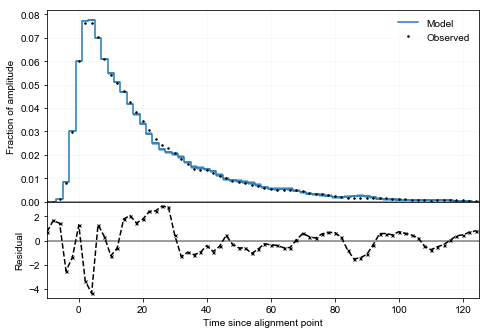

Reading stat error from stored_stat parameter!
chi2 = 1.647148


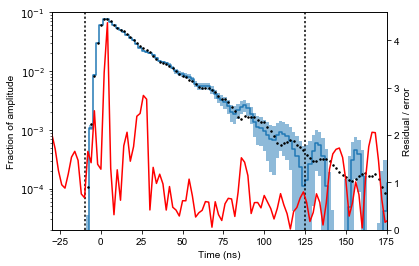

In [95]:
minrow['error_offset'] = 1e-4
minrow['error_pct'] = 0.01
plot_model(**minrow)

#### Check a few local minima

We have seen some spread in the best fit point... Especially if close together. Here the following approach: take the best n fits, recompute chi2 and see if anything changes. If it does, maybe increase stats, but for these points only?

In [173]:
el2 = check_minima(df, 5, 5)

Selected 5 values with chi2 ranging from 1.27 to 1.29...
Working on setting 107
Reading stat error from stored_stat parameter!
gof=1.2190988163780587, fs=0.22, t1=1.5, t3=21.0, tts=1.5
Reading stat error from stored_stat parameter!
gof=1.2485126891707856, fs=0.22, t1=1.5, t3=21.0, tts=1.5
Reading stat error from stored_stat parameter!
gof=1.2837532115234893, fs=0.22, t1=1.5, t3=21.0, tts=1.5
Reading stat error from stored_stat parameter!
gof=1.2748591308164972, fs=0.22, t1=1.5, t3=21.0, tts=1.5
Reading stat error from stored_stat parameter!
gof=1.24463653903149, fs=0.22, t1=1.5, t3=21.0, tts=1.5
Working on setting 107
Reading stat error from stored_stat parameter!
gof=1.2012328782598831, fs=0.22, t1=1.5, t3=21.0, tts=1.5
Reading stat error from stored_stat parameter!
gof=1.3235179053828903, fs=0.22, t1=1.5, t3=21.0, tts=1.5
Reading stat error from stored_stat parameter!
gof=1.2921495056536856, fs=0.22, t1=1.5, t3=21.0, tts=1.5
Reading stat error from stored_stat parameter!
gof=1.452645

In [174]:
el2

,bootstrap_trials,chi2,dset,fs,n_photons,neglect_systematic,t1,t3,tts,ranking_before,chi2_new_5_times,ranking_after
107,250,1.273933,nr,0.22,2000000,False,1.5,21.0,1.50,0,1.254172,0
107,250,1.273933,nr,0.22,2000000,False,1.5,21.0,1.50,1,1.323439,2
591,250,1.282838,nr,0.24,2000000,False,1.0,21.5,1.75,3,1.356197,3
591,250,1.282838,nr,0.24,2000000,False,1.0,21.5,1.75,2,1.384112,4
653,250,1.292329,nr,0.24,2000000,False,2.0,22.0,1.50,4,1.299477,1


In [172]:
el

,bootstrap_trials,chi2,dset,fs,n_photons,neglect_systematic,t1,t3,tts,ranking_before,chi2_new_5_times,ranking_after
65,250,1.596387,nr,0.25,2000000,False,2.0,22.5,1.50,0,1.630300,0
10,250,1.759036,nr,0.25,2000000,False,1.5,22.0,1.75,1,1.693299,2
3,250,1.798394,nr,0.25,2000000,False,1.0,22.0,1.75,2,1.686337,1
114,250,1.924941,nr,0.25,2000000,False,2.0,23.0,1.50,3,1.854230,3
59,250,2.053049,nr,0.25,2000000,False,1.5,22.5,1.75,4,2.036419,4


## Fit stability

The current grid is not good enough. The values of chi2 are fluctuating a LOT, so that we get wrong minima. If we use a local minimizer, this is going to fail spectecularly. The values are essentially random if we are close to a mimimum.

The stability of chi^2 depends on a couple of things... The error is now composed of:
  * statistical error on data. Determined by bootstrap resampling. Depends on number of bootstrap trials.
  * Average waveform stability. Depends on number of photons.
  * Including systematical error in the average wf
  
Here we check how we can push these errors (or fluctuations) down. We take the point that came out of the previous minimization (though it can be a false minimum). 

In [63]:
popt = dict(df.iloc[df['chi2'].argmin()])

### Statistics

Here we investigate the influence of the statistics of the number of photons. To isolate this effect, first:
  * turn off systematic errors
  * take a giant amount of bootstrap samples (will vary this later)
  

In [66]:
popt['neglect_systematic'] = True

In [65]:
del stored_stat
stored_stat = real_s1_wv_sigma(bootstrap_trials = 2000)

In [73]:
gofs_list = []
nph_scan = [int(2e5), int(4e5), int(2e6)]
for nph in nph_scan:
    print(nph)
    popt['n_photons'] = nph
    gofs_list.append([gof(**popt) for _ in range(30)])

200000
Reading stat error from stored_stat parameter!
gof=4.847686336182956, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=5.893724830132279, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=5.6621421313708025, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=4.960056160807073, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=5.036084011427087, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=5.435783839662097, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=5.426565338782284, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=5.506808589426186, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=4.377088315327442, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!


In [88]:
nph_scan = [int(2e5), int(4e5), int(2e6), int(4e6)]

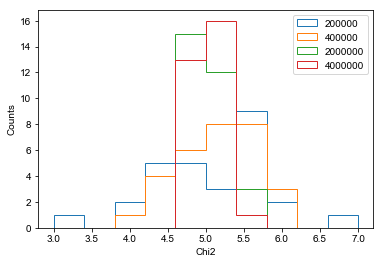

In [89]:
for gofs, l in zip(gofs_list, nph_scan):
    plt.hist(gofs, histtype = 'step', bins=10, range=(3,7), label='%d' % l)
plt.xlabel('Chi2')
plt.ylabel('Counts')
plt.legend()
plt.show()

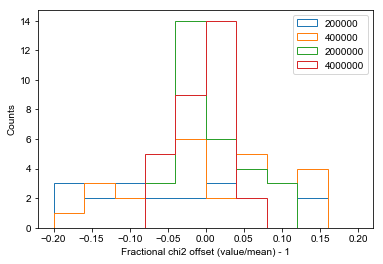

In [90]:
for gofs, l in zip(gofs_list, nph_scan):
    plt.hist(np.array(gofs) / np.mean(gofs) - 1, histtype = 'step', bins=10, range=(-.2,.2), label='%d' % l)
plt.xlabel('Fractional chi2 offset (value/mean) - 1')
plt.ylabel('Counts')
plt.legend()
plt.show()

In [91]:
np.std(gofs_list, axis=1) / np.mean(gofs_list, axis=1)

array([ 0.18106677,  0.10032424,  0.04895351,  0.0351447 ])

In [92]:
gofs_list_stat = []
nph_scan = [int(2e5), int(4e5), int(2e6)]
popt['neglect_systematic'] = False
for nph in nph_scan:
    print(nph)
    popt['n_photons'] = nph
    gofs_list_stat.append([gof(**popt) for _ in range(30)])

200000
Reading stat error from stored_stat parameter!
gof=2.994595859402191, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=1.7180867413599614, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=2.581299280602138, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=2.3044093119377864, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=3.87797057226319, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=2.3584730945375254, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=2.9466589522782445, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=2.2913916890875003, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=1.8378287717356594, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat paramet

In [94]:
np.std(gofs_list_stat, axis=1) / np.mean(gofs_list_stat, axis=1)

array([ 0.26617473,  0.19006954,  0.06307608])

#### The money plot

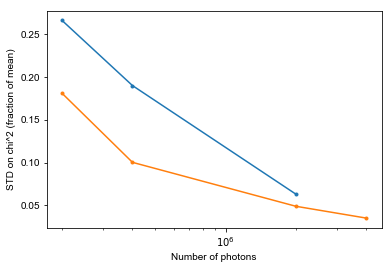

In [125]:
plt.plot(nph_scan, np.std(gofs_list_stat, axis=1) / np.mean(gofs_list_stat, axis=1), marker='.')
plt.plot(np.concatenate([nph_scan, [int(4e6)]]), np.std(gofs_list, axis=1) / np.mean(gofs_list, axis=1), marker='.')
plt.xscale('log')
plt.xlabel('Number of photons')
plt.ylabel('STD on chi^2 (fraction of mean)')

### Number of bootstrap trials

In [129]:
popt['n_photons'] = int(1e6)
popt['stored_stat'] = False

boot_scan = [20, 100, 200, 1000]
boots = []
for bt in boot_scan:
    print(bt)
    popt['bootstrap_trials'] = bt
    boots.append([gof(**popt) for _ in range(20)])


20
gof=1.934865562922848, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.294249914987514, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.897927975499547, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.20651953781785, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.3404212287590673, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.824898948772344, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.8283130743557883, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.452338891592939, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.0894702055698833, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.5820449784985073, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.9172095355070393, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.789504337155653, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.4301882420563343, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.544293321063236, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.240761883540313, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.4581112505576193, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.3309261638355525, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=

KeyboardInterrupt: 

In [135]:
for bt in [400]:
    print(bt)
    popt['bootstrap_trials'] = bt
    boots.append([gof(**popt) for _ in range(20)])

400
gof=2.169790799650517, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.0958783567618977, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.0437041529418414, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.189776783448054, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.335455337573744, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.016523940034678, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.957150616151253, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.2426380687513316, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.0268897915146216, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.7702937134946244, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.2007160689622935, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.8613155479428471, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.138296685063111, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.0494810091269486, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.7838359820359413, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.880781820935462, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.299482036700427, fs=0.19, t1=2.0, t3=25.0, tts=1.75
g

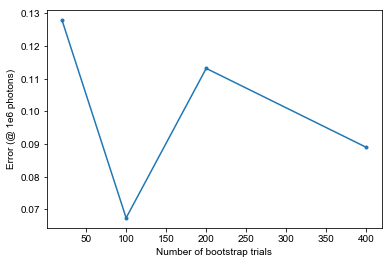

In [136]:
plt.plot([20, 100, 200, 400], np.std(boots, axis=1) / np.mean(boots, axis=1), marker='.')
plt.xlabel('Number of bootstrap trials')
plt.ylabel('Error (@ 1e6 photons)')

It looks like at 1M photons, the number of bootstrap trials is not so important as long as it is high enough (>= 100)

### Normalization check

In [115]:
popt = dict(df.iloc[df['chi2'].argmin()])

In [116]:
popt

{'chi2': 0.69103473385688463, 'fs': 0.19, 't1': 2.0, 't3': 25.0, 'tts': 1.75}

In [117]:
ydata, _ = real_s1_wv(**popt)
minus, base, plus = s1_models_error(**popt)

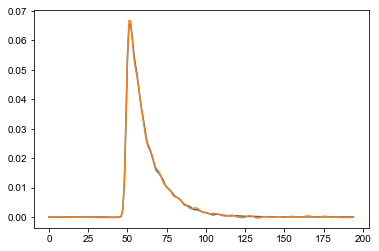

In [118]:
plt.plot(ydata)
plt.plot(base)
# plt.yscale('log')

In [119]:
np.sum(ydata)

1.0100332563949541

In [120]:
np.sum(base)

1.0033517421650893

In [121]:
sel = (spe_ts >= default_params['t_min']) & (spe_ts < default_params['t_max'])

In [122]:
np.sum(base[sel])

0.99999999999999989

In [123]:
np.sum(ydata[sel])

0.99999999999999989

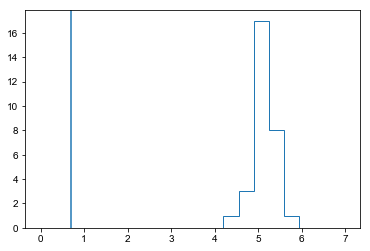

In [44]:
plt.hist(gofs, histtype='step', bins=20, range = (0, 7))
plt.axvline(0.69)

{'tr': 15, 'neglect_statistical': False, 's1_min': 30, 'tts': 1.75, 'stored_stat': True, 'eta': 0.0, 'f_r': 0.0, 'error_offset': 0.0001, 'fs': 0.19, 'error_pct': 0.0, 't1': 2.0, 'fs_r': 0.2, 'n_photons': 2000000, 't_min': -10.0, 'aft': 0.28, 't_max': 125.0, 't3': 25.0, 'dset': 'er', 'neglect_systematic': True, 'bootstrap_trials': 100, 'chi2': 0.69103473385688463, 's1_sample': 'data', 's1_model': 'two_exp', 's1_max': 100}
Reading stat error from stored_stat parameter!


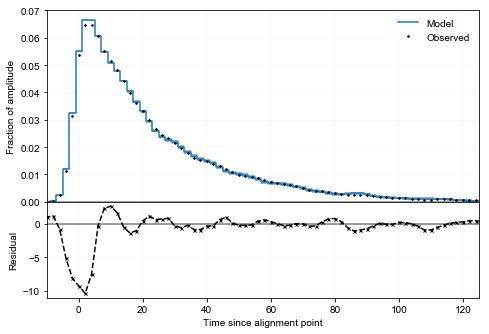

Reading stat error from stored_stat parameter!
chi2 = 5.631036


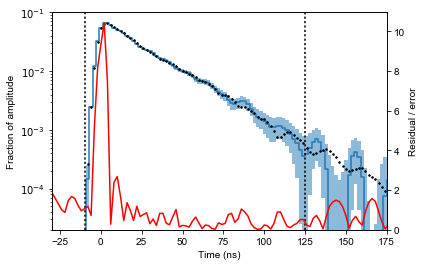

In [45]:
plot_model(**popt)

## Consistency check

Is the chi2 computed by me the same as the one found by Stoomboot? Here we take random parameters from the grid, compute the chi2 twice and compare how much *they* vary with the variation found within one of the computed lists and the original calculation.

In [19]:
stored_stat = real_s1_wv_sigma(**(df.iloc[0]))

In [20]:
bla1 = []
bla2 = []
bla3 = []
for i in range(40):
    randrow = df.iloc[np.random.randint(0, len(df))]
    bla1.append(randrow['chi2'])
    bla2.append(gof(**randrow))
    bla3.append(gof(**randrow))

bla1 = np.array(bla1)
bla2 = np.array(bla2)
bla3 = np.array(bla3)

Reading stat error from stored_stat parameter!
gof=22.197856331672842, fs=0.17, t1=4.0, t3=24.5, tts=2.0
Reading stat error from stored_stat parameter!
gof=22.583376867497908, fs=0.17, t1=4.0, t3=24.5, tts=2.0
Reading stat error from stored_stat parameter!
gof=4.965032019046841, fs=0.19, t1=3.0, t3=24.5, tts=1.75
Reading stat error from stored_stat parameter!
gof=5.431545308357935, fs=0.19, t1=3.0, t3=24.5, tts=1.75
Reading stat error from stored_stat parameter!
gof=11.32994879215754, fs=0.19, t1=3.5, t3=27.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=11.983827961949077, fs=0.19, t1=3.5, t3=27.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=32.99290719548175, fs=0.19, t1=4.0, t3=27.5, tts=2.0
Reading stat error from stored_stat parameter!
gof=31.983095950302012, fs=0.19, t1=4.0, t3=27.5, tts=2.0
Reading stat error from stored_stat parameter!
gof=9.878493140419518, fs=0.18, t1=2.5, t3=25.5, tts=2.0
Reading stat error from stored_stat parameter!
gof=9.096

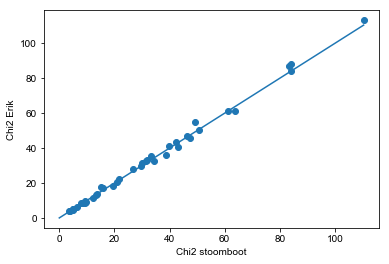

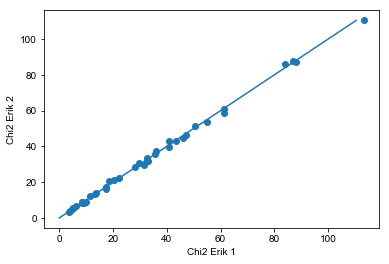

In [21]:
plt.scatter(bla1, bla2)
plt.xlabel('Chi2 stoomboot')
plt.ylabel('Chi2 Erik')
plt.plot((0, max(bla1)), (0, max(bla1)), label='x = y')
plt.show()

plt.scatter(bla2, bla3)
plt.xlabel('Chi2 Erik 1')
plt.ylabel('Chi2 Erik 2')
plt.plot((0, max(bla1)), (0, max(bla1)), label='x = y')
plt.show()

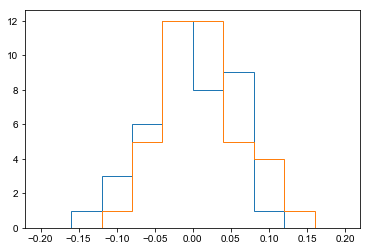

In [24]:
plt.hist((bla1 - bla2)/bla2, histtype='step', range=(-0.2, 0.2))
plt.hist((bla3 - bla2)/bla2, histtype='step', range=(-0.2, 0.2))
plt.show()

In [154]:
def get_step(df, key):
    return np.diff(np.sort(np.unique(df[key].values)))[0]

In [158]:
get_step(df, 'tts')

0.25

In [159]:
# Using half the step size that was used for the array
minimize_it(['t3', 'fs', 't1', 'tts'], [p['t3'], p['fs'], p['t1'], p['tts']], np.diag([0.25, 0.005, 0.125, 0.125]),
            **p)

gof=6.835846844545791, fs=0.17, t1=3.0, t3=25.5, tts=1.5
gof=4.484094011008079, fs=0.17, t1=3.0, t3=25.5, tts=1.5
gof=6.2844180095350906, fs=0.17, t1=3.0, t3=25.75, tts=1.5
gof=4.862439342731491, fs=0.17, t1=3.0, t3=25.0954915, tts=1.5
gof=3.9725227966964707, fs=0.17, t1=3.0, t3=25.5, tts=1.5
gof=5.434138959779439, fs=0.17, t1=3.0, t3=25.345491506289, tts=1.5
gof=5.027767432967841, fs=0.17, t1=3.0, t3=25.5954915, tts=1.5
gof=5.076779842304964, fs=0.17, t1=3.0, t3=25.480397956650467, tts=1.5
gof=3.544497781931108, fs=0.17, t1=3.0, t3=25.5383084058366, tts=1.5
gof=3.574977330723969, fs=0.17, t1=3.0, t3=25.53352875702835, tts=1.5
gof=4.069563351814927, fs=0.17, t1=3.0, t3=25.560150403581815, tts=1.5
gof=5.224178093486836, fs=0.17, t1=3.0, t3=25.558208239191778, tts=1.5
gof=4.287354977175526, fs=0.17, t1=3.0, t3=25.545909465583943, tts=1.5
gof=6.466368417898476, fs=0.17, t1=3.0, t3=25.54121175222405, tts=1.5
gof=5.806879909958351, fs=0.17, t1=3.0, t3=25.536482742499906, tts=1.5
gof=4.49084

   direc: array([[ 0.        ,  0.        ,  0.        ,  0.125     ],
       [ 0.        ,  0.005     ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.125     ,  0.        ],
       [ 0.01414336,  0.00298687,  0.10319376, -0.01286558]])
     fun: 3.6640978152315884
 message: 'Optimization terminated successfully.'
    nfev: 232
     nit: 4
  status: 0
 success: True
       x: array([ 25.59844703,   0.19016726,   4.14462378,   1.23759645])